In [1]:
#Plot the predictions, saliencies and MRIs for figure 8

In [6]:
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH
from meld_classifier.experiment import Experiment
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_classifier.dataset import load_combined_hemisphere_data, Dataset, normalise_data
from meld_classifier.training import Trainer
from meld_classifier.evaluation import Evaluator
import os
import json
import glob
import h5py
import numpy as np
import nibabel as nb
from nilearn import plotting, image
# import logging
# # set logging to debug to see all messages (set to INFO in real scripts)
# logging.basicConfig(level=logging.FATAL)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import gridspec
import matplotlib_surface_plotting as msp

def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

from PIL import Image
import subprocess

In [7]:
c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')

import meld_classifier.mesh_tools as mt
import meld_classifier.paths as paths

surf = mt.load_mesh_geometry(os.path.join(paths.BASE_PATH,'fsaverage_sym',
                                          'surf','lh.partial_inflated'))

In [8]:
def create_surface_plots(surf,prediction,c, boundary):
    """plot and reload surface images"""
    parcel_cmap = {0:np.array([0,0,0,1]),
                  1:np.array([0,0,0,1]),
                  }
    msp.plot_surf(surf['coords'],surf['faces'],prediction,
              rotate=[90],
              mask=prediction==0,pvals=np.ones_like(c.cortex_mask),
              colorbar=False,vmin=0,vmax=1,cmap='turbo',
              parcel=boundary,parcel_cmap=parcel_cmap,
              base_size=20,
              filename='tmp.png'
             );
    subprocess.call(f"convert ./tmp.png -trim ./tmp1.png", shell=True)
    im = Image.open('tmp1.png')
    im = im.convert("RGBA")
    im1 = np.array(im)
    msp.plot_surf(surf['coords'],
                                           surf['faces'],prediction,
              rotate=[270],
              mask=prediction==0,pvals=np.ones_like(c.cortex_mask),
              colorbar=False,vmin=0,vmax=1,cmap='turbo',
              parcel=boundary,parcel_cmap=parcel_cmap,
              base_size=20,
              filename='tmp.png'
             );
    subprocess.call(f"convert ./tmp.png -trim ./tmp1.png", shell=True)
    im = Image.open('tmp1.png')
    im = im.convert("RGBA")
    im2 = np.array(im)
    plt.close('all')
    return im1,im2

In [9]:
subjects=['MELD_H4_3T_FCD_0011','MELD_H16_3T_FCD_004',]


/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/nilearn/plotting/displays.py:776: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


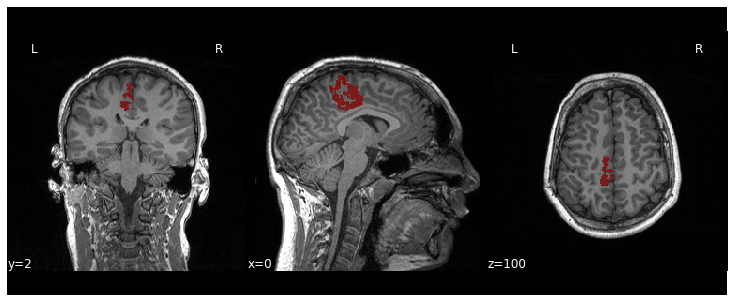

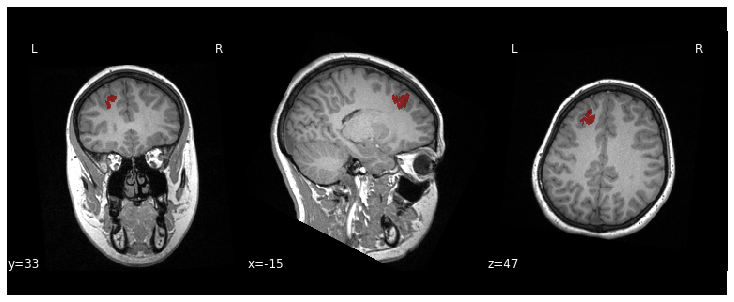

In [12]:
# create prediction on MRI 
subjects=['MELD_H4_3T_FCD_0011','MELD_H16_3T_FCD_004',]


for subject in subjects : 
    fig = plt.figure(figsize=(10,4))
    # Open their MRI data if available
    t1_file = f'/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/fs_outputs/{subject}/mri/orig.nii'
#     lesion_file = f'/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/fs_outputs/{subject}/mri/lh.lesion.nii'
    prediction_file_lh = f'/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/fs_outputs/{subject}/mri/lh.prediction.nii'
    prediction_file_rh = f'/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/fs_outputs/{subject}/mri/rh.prediction.nii'
    # load image
    imgs={'anat' : nb.load(t1_file),
          'pred_lh' : nb.load(prediction_file_lh), 
          'pred_rh' : nb.load(prediction_file_rh)}  

    # Resample and move to same shape and affine than t1
    imgs['pred_lh'] = image.resample_img(imgs['pred_lh'], target_affine=imgs['anat'].affine, target_shape=imgs['anat'].shape, 
                                         interpolation='nearest', copy=True, 
                                         order='F', clip=False, fill_value=0, force_resample=False)
    imgs['pred_rh'] = image.resample_img(imgs['pred_rh'], target_affine=imgs['anat'].affine, target_shape=imgs['anat'].shape, 
                                         interpolation='nearest', copy=True, 
                                         order='F', clip=False, fill_value=0, force_resample=False)  

    mask = image.math_img("img2 + img3", img2=imgs['pred_lh'], img3=imgs['pred_rh'])

    coords = plotting.find_xyz_cut_coords(mask)
    vmax = np.percentile(imgs['anat'].get_fdata(), 99)
    display = plotting.plot_anat(t1_file, colorbar=False, cut_coords=coords, draw_cross= False,  vmax = vmax, figure=fig,)
    display.add_contours(prediction_file_lh, filled=True, alpha=0.7, levels=[0.5], colors='darkred')
    display.add_contours(prediction_file_rh, filled=True, alpha=0.7, levels=[0.5], colors='darkred')
    plt.tight_layout()
    
    fig.savefig(f'/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/predictions/prediction_{subject}_2.png', facecolor='black') 
    

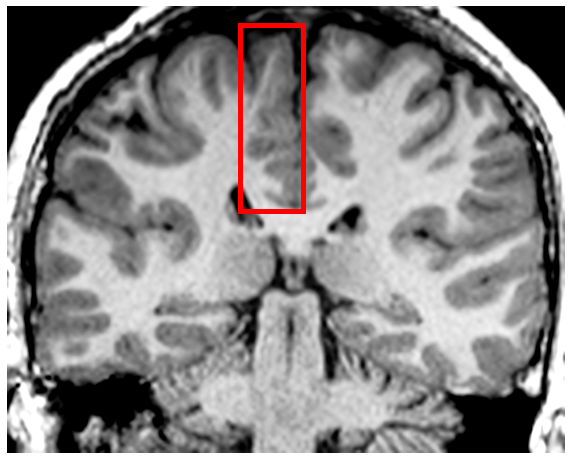

In [82]:
flair_im='/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/fs_outputs/MELD_H4_3T_FCD_0011/mri/orig.mgz'
flair_im=nb.load(flair_im).dataobj[:]
flair=np.fliplr(flair_im[50:200,40:160,106].T)
from scipy import ndimage
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndimage.zoom(flair,4),cmap='Greys_r',vmin=30,vmax=135)
ax.axis('off')
a=plt.Rectangle([250,20],68,200,edgecolor='r',fill=None,lw=5)
ax.add_patch(a)
fig.savefig('/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/predictions/zoomed_t1_flair.png')

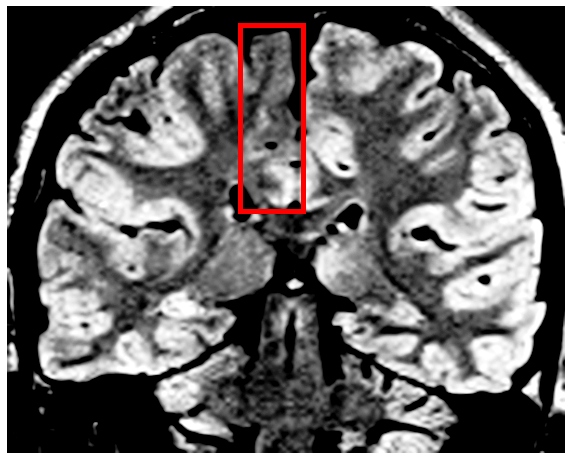

In [83]:
flair_im='/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/fs_outputs/MELD_H4_3T_FCD_0011/mri/FLAIR.mgz'
flair_im=nb.load(flair_im).dataobj[:]
flair=np.fliplr(flair_im[50:200,40:160,106].T)
from scipy import ndimage
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndimage.zoom(flair,4),cmap='Greys_r',vmin=100,vmax=150)
ax.axis('off')
a=plt.Rectangle([250,20],68,200,edgecolor='r',fill=None,lw=5)
ax.add_patch(a)
fig.savefig('/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/predictions/zoomed_FLAIR.png')

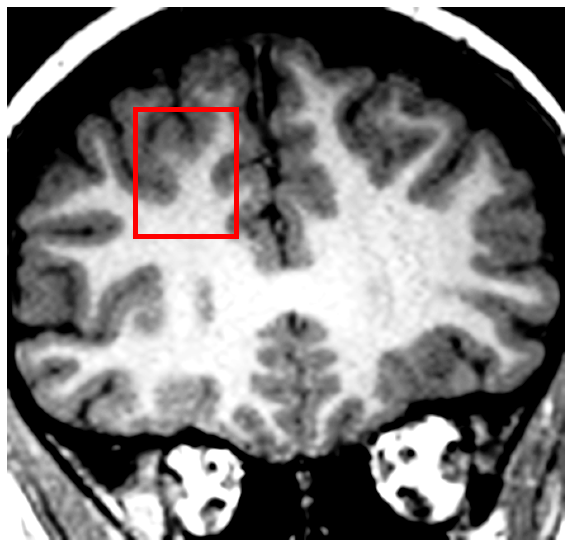

In [68]:
t1_im='/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/fs_outputs/MELD_H16_3T_FCD_004/mri/orig.mgz'
t1_im=nb.load(t1_im).dataobj[:]
t1=np.fliplr(t1_im[70:180,45:150,163].T)
from scipy import ndimage
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndimage.zoom(t1,4),cmap='Greys_r',vmin=60,vmax=135)
ax.axis('off')
a=plt.Rectangle([100,80],80,100,edgecolor='r',fill=None,lw=5)
ax.add_patch(a)
fig.savefig('/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/predictions/zoomed_T1.png')

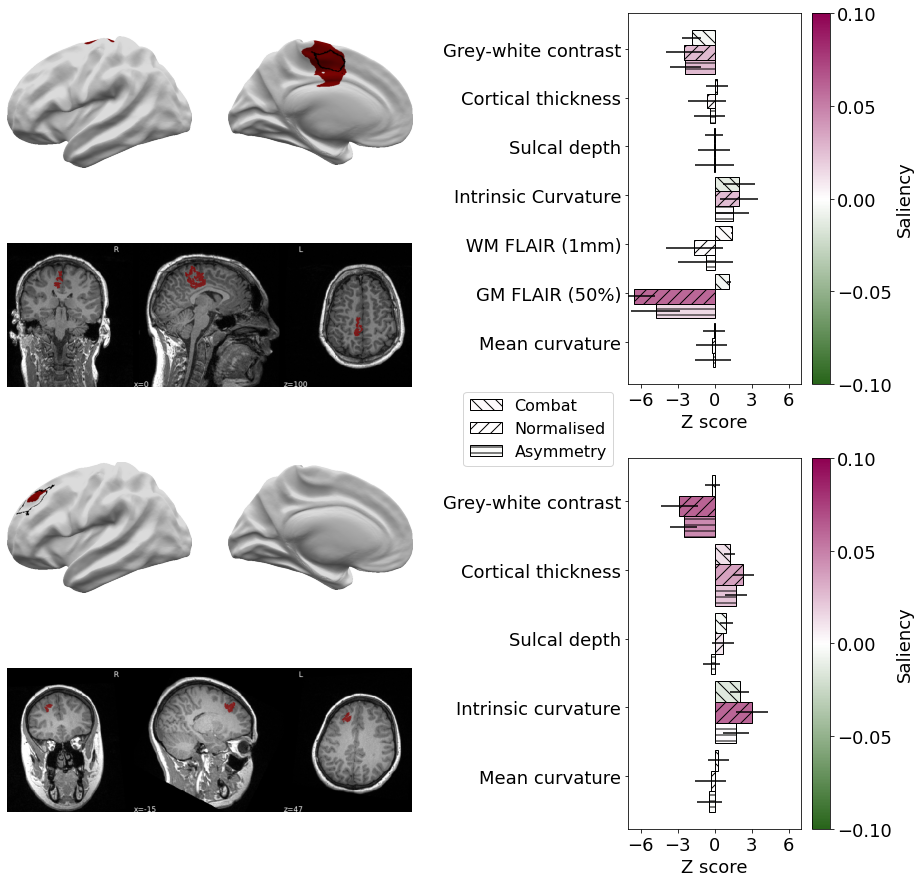

In [15]:
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
# fig = plt.figure(figsize=(15,15))
# gs = GridSpec(4, 3, width_ratios=[1, 1,2], height_ratios=[ 1,2,1,2],
#              wspace=0.1,hspace=0.5)

fig = plt.figure(figsize=(15,15))
gs1 = GridSpec(4, 2, right=0.5)
gs2 = GridSpec(2, 1, left=0.7)

subjects=['MELD_H4_3T_FCD_0011','MELD_H16_3T_FCD_004',]
base_feature_sets = [['.on_lh.curv.sm5.mgh',
                         '.on_lh.gm_FLAIR_0.5.sm10.mgh',
                     '.on_lh.wm_FLAIR_1.sm10.mgh',
                         '.on_lh.pial.K_filtered.sm20.mgh',
                         '.on_lh.sulc.sm5.mgh',
                         '.on_lh.thickness.sm10.mgh',
                         '.on_lh.w-g.pct.sm10.mgh',
                         ],['.on_lh.curv.sm5.mgh',
                         '.on_lh.pial.K_filtered.sm20.mgh',
                         '.on_lh.sulc.sm5.mgh',
                         '.on_lh.thickness.sm10.mgh',
                         '.on_lh.w-g.pct.sm10.mgh',
                         ]]

feature_names_sets = [['Mean curvature',
                         'GM FLAIR (50%)',
                         ' WM FLAIR (1mm)',
                         'Intrinsic Curvature',
                         'Sulcal depth',
                         'Cortical thickness',
                         'Grey-white contrast',],
    ['Mean curvature',
                        # 'GM FLAIR (50%)',
                         #' WM FLAIR (1mm)',
                         'Intrinsic curvature',
                         'Sulcal depth',
                         'Cortical thickness',
                         'Grey-white contrast',]]

#fig, axs = plt.subplots(2,3, figsize=(15,10)) #, sharey=True, sharex=True)
stored=[]
for s,subject in enumerate(subjects):
    base_features=base_feature_sets[s]
    feature_names=feature_names_sets[s]
    subj = MeldSubject(subject,cohort=c)
    if 'FCD' in subject:
        group = 'patient'
        pair_subject=subject
    else:
        group = 'control'
        pair_subject = np.random.choice(patients)
        print(subject + ' pair with ' + pair_subject)
        patients.remove(pair_subject)
    #split hemi
    try:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    except KeyError:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    features=subj.get_feature_list()
    #print(features)
    labels_hemis = {}
    features_hemis={}
    for hemi in ['lh','rh']:
        features_hemis[hemi], labels_hemis[hemi] = subj.load_feature_lesion_data(
            features, hemi=hemi, features_to_ignore=[]
        )
        features_hemis[hemi]=normalise_data(features_hemis[hemi],features,
                                               'normalise_params_6_with0.json')
    hemi='lh'
    prediction = np.zeros(len(c.cortex_mask))
    prediction[c.cortex_mask] = result_hemis[hemi]
    label =labels_hemis[hemi]
    
    EXPERIMENT_PATH='/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1'
    exp_path = os.path.join(EXPERIMENT_PATH, 'iteration_21-09-15', 'ensemble_21-09-15', 'fold_all')
    exp_name = 'ensemble_iteration'

    with h5py.File(hdf_predictions, 'r') as f:
        subj_id=subject
        igp=f[subj_id]['lh']['integrated_gradients_pred'][:]
    
    exp = Experiment(experiment_path=exp_path, experiment_name=exp_name)
    feat = exp.get_features()[0]
    saliency_features = exp.get_features()[0]

    im1,im2=create_surface_plots(surf,prediction=prediction,c=c, boundary=label)
    stored.append([im1,im2])
#     im=Image.open('sub1_prediction.png')
    ax = fig.add_subplot(gs1[s*2, 0])

    ax.imshow(im1)
    ax.axis('off')
    ax = fig.add_subplot(gs1[s*2, 1])
    ax.imshow(im2)
    ax.axis('off')
    a=Image.open(f'/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/predictions/prediction_{subject}_2.png')
    ax = fig.add_subplot(gs1[s*2+1, :2])
    ax.imshow(np.array(a)[30:-27,37:-35])
    ax.axis('off')
    
    prefixes = ['.combat','.inter_z.intra_z.combat',
               '.inter_z.asym.intra_z.combat']
    names=['combat','norm', 'asym']
    import matplotlib as mpl
    import matplotlib.cm as cm

    lims = np.max([-0.1,0.1])
    #lims = np.max([-0.01,0.01])

    norm = mpl.colors.Normalize(vmin=-lims, vmax=lims)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('grpr',colors=['#276419','#FFFFFF','#8E0152',])

    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    labels=['Combat','Normalised','Asymmetry']
    hatching = ['\\\\','//','--']
    ax = fig.add_subplot(gs2[s])
    for pr,prefix in enumerate(prefixes):
        cur_data = np.zeros(len(base_features))
        cur_err = np.zeros(len(base_features))
        saliency_data = np.zeros(len(base_features))
        for b,bf in enumerate(base_features):
            cur_data[b] = np.mean(features_hemis['lh'][prediction==1,features.index(prefix+bf)])
            cur_err[b] = np.std(features_hemis['lh'][prediction==1,features.index(prefix+bf)])

            saliency_data[b] = np.mean(igp[prediction[c.cortex_mask]==1,saliency_features.index(prefix+bf)])

        ax.barh(y=np.array(range(len(base_features)))-pr*0.3, width=cur_data,hatch= hatching[pr],
                     height=0.3, edgecolor='k',xerr=cur_err,label=labels[pr],
               color=m.to_rgba(saliency_data))

    ax.set_xlim([-7,7])
    #ax.set_xlim([-3,3])

    ax.set_xticks([-6,-3,0,3,6])
    #ax.set_xticks([-2,-1,0,1,2])

    ax.set_yticks(np.array(range(len(base_features)))-0.23)    ;                          
    ax.set_yticklabels(feature_names)    ; 
    ax.set_xlabel('Z score')
    fig.colorbar(m,label='Saliency',ax=ax,ticks=[-0.1,-0.05,0,0.05,0.1],
                )
    ax.set_autoscale_on(True)
ax.legend(loc='upper left', bbox_to_anchor=(-1, 1.2), fontsize=16)    
fig 

In [38]:
imgs=[Image.fromarray(im1),Image.fromarray(im2)]


imgs_comb = Image.fromarray( imgs_comb)

/home/kw350/.conda/envs/meld/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


In [79]:
comb = np.zeros((np.max([stored[0][0].shape[0],stored[0][1].shape[0]]),
                 np.max([stored[0][0].shape[1],stored[0][1].shape[1]])*2,4),dtype='uint8')
comb[:stored[0][0].shape[0],:stored[0][0].shape[1],:]=stored[0][0]
comb[-stored[0][1].shape[0]:,-stored[0][1].shape[1]:,:]=stored[0][1]
im=Image.fromarray(comb)
im.save('/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/predictions/predictions_sub1.png')

In [80]:
comb = np.zeros((np.max([stored[1][0].shape[0],stored[1][1].shape[0]]),
                 np.max([stored[1][0].shape[1],stored[1][1].shape[1]])*2,4),dtype='uint8')
comb[:stored[1][0].shape[0],:stored[1][0].shape[1],:]=stored[1][0]
comb[-stored[1][1].shape[0]:,-stored[1][1].shape[1]:,:]=stored[1][1]
im=Image.fromarray(comb)
im.save('/rds/project/kw350/rds-kw350-meld/meld_data/Example_pts/predictions/predictions_sub2.png')